_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [21]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._

### Part 1

In [22]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51916 entries, 0 to 51915
Data columns (total 17 columns):
Inspection ID      51916 non-null int64
DBA Name           51916 non-null object
AKA Name           51293 non-null object
License #          51911 non-null float64
Facility Type      51692 non-null object
Risk               51904 non-null object
Address            51916 non-null object
City               51863 non-null object
State              51906 non-null object
Zip                51890 non-null float64
Inspection Date    51916 non-null object
Inspection Type    51915 non-null object
Violations         42261 non-null object
Latitude           51718 non-null float64
Longitude          51718 non-null float64
Location           51718 non-null object
Fail               51916 non-null int64
dtypes: float64(4), int64(2), object(11)
memory usage: 6.7+ MB


In [34]:
X_train = train.drop(columns='Fail')
y_train = train['Fail']
X_test = test.drop(columns='Fail')
y_test = test['Fail']

In [35]:
def clean_nan(X):
    """Function to clean nans from data set"""
    X = X.copy()
    num = X.select_dtypes(include='number')
    cat = X.select_dtypes(exclude='number')
    num = num.fillna(num.mean())
    cat = cat.fillna('missing')
    
    # merge dataframes back to 1
    X = pd.merge(num, cat, how='left', left_on=num.index, right_on=cat.index)
    X = X.drop(columns='key_0')
    
    return X
    
X_train = clean_nan(X_train)
X_test = clean_nan(X_test)

In [36]:
X_train.shape, X_test.shape

((51916, 16), (17306, 16))

In [37]:
import category_encoders as ce

# Categorical encoding
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

X_train.shape, X_test.shape

((51916, 16), (17306, 16))

### Part 2

In [38]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(2, 4)
}

search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42),
    param_distributions=param_dist,
    n_iter=2,
    scoring='roc_auc',
    n_jobs=-1,
    cv=3,
    verbose=10,
    return_train_score=True,
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   19.6s remaining:   39.4s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   19.7s remaining:   19.7s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   20.4s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   24.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   24.3s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026902A84588>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002696E73EB38>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [39]:
search.best_score_

0.7019628337981463

### Part 3

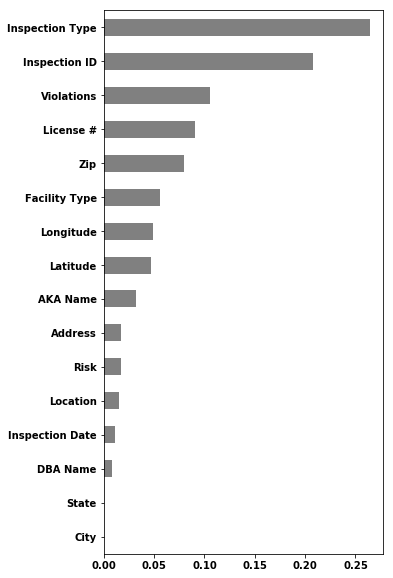

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

best = search.best_estimator_
n = len(X_train.columns)
figsize = (5, 10)

importances = pd.Series(best.feature_importances_, X_train.columns)
top_n = importances.sort_values()[-n:]
plt.figure(figsize=figsize)
top_n.plot.barh(color='gray');

### Part 4

What does Gradient Descent seek to minimize?

- Gradient descent seeks to minimize some function by iteratively moving in the direction of steepest descent as defined by the negative of the gradient (slope).

What is the "Learning Rate" and what is its function?

- The learning rate is the size of each iterative step. So, a high learning rate covers more ground, but is less precise, and a low learning rate covers less ground, but is more precise.